## ***Uncertainty Quantification***

Prof. Dr. M. Frank 2021

------------------------------------------------------------------------

#### **EXERCISE SHEET 7**

In [1]:
!pip install ghalton
import numpy as np
import sobol_seq
from pyDOE import *
import matplotlib.pyplot as plt
import math
import ghalton

&nbsp;

**EXERCISE 1)**

In this exercise, we revisit Exercise Sheet 2, in which we studied the convergence of Monte-Carlo. Go over the exercise again and think about how your answers (especially regarding task (d) ) differs from your answer when you started the course. Discuss which method should be used for which problem to mitigate the curese of dimensionality.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   a) In this section we compare different random numbers to approximate the value of  π . What does the code do exactly?

In [4]:
def generateSamples (N):
  samples=np.empty((N,2,5))
  labels=list()
  # MC
  samples[:,:,0]=np.random.uniform(0,1,(N,2))
  labels.append('Monte Carlo')

  # Latin hypercube
  samples[:,:,1]=lhs(2,samples=N,criterion="c")
  labels.append('Latin Hyp')

  # Halton Set
  sequencer = ghalton.Halton(2)
  #halton_sample = sequencer.get(N)
  #tfp.mcmc.sample_halton_sequence(2, N,randomized=True, seed=127)
  samples[:,:,2] = sequencer.get(N)
  labels.append('Halton')

  # Sobol Set
  samples[:,:,3]=sobol_seq.i4_sobol_generate(2, N)
  labels.append('Sobol')

  # Additive Recurrence
  alphax=np.random.uniform(0,1,(1,1))
  alphay=np.random.uniform(0,1,(1,1))
  x=np.cumsum(np.ones((N,1))*alphax)%1
  y=np.cumsum(np.ones((N,1))*alphay)%1
  samples[:,0,4]=x
  samples[:,1,4]=y
  labels.append('Additive rec')

  return [samples,labels]

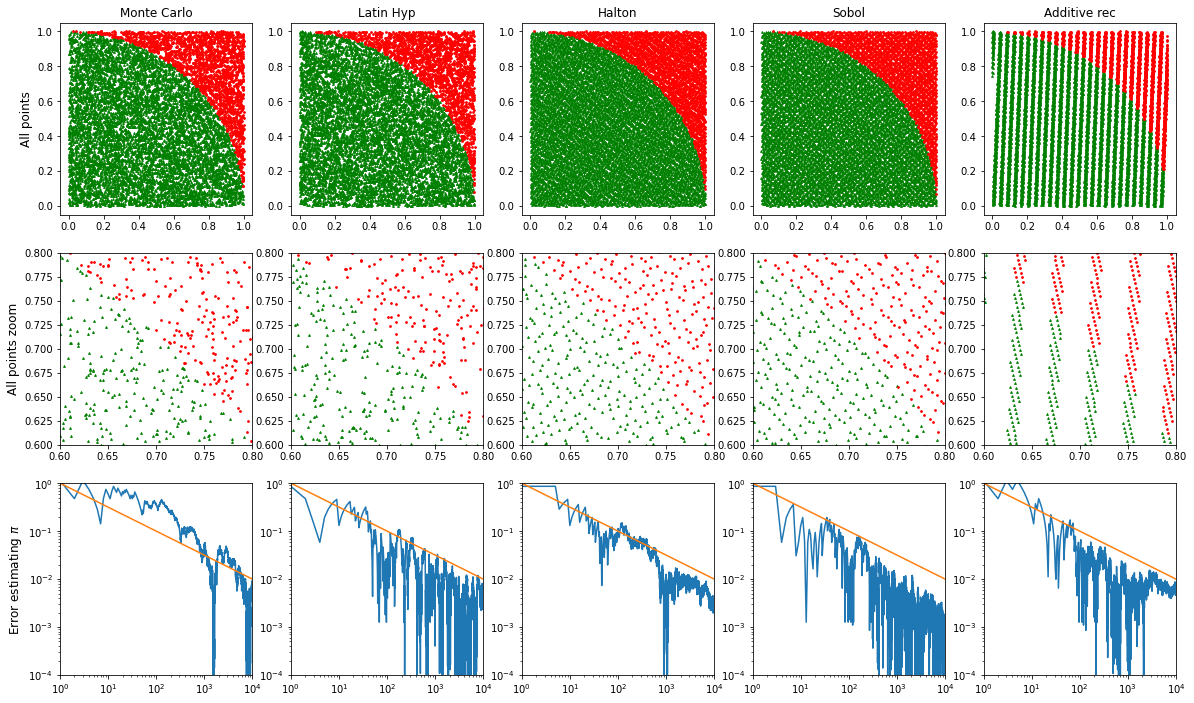

In [9]:
#Numbers of samples 
N=10000

#Generate samples
[samples,labels]=generateSamples(N)

K= np.size(samples,2)

#Check whether samples fall into unit circle
inside=np.empty((N,K),dtype=bool)

for k in range(K):
  inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)

#Plot results
fig, ax = plt.subplots(3,K,figsize=(4*K, 12))

for k in range(K):

  #label axes
  ax[0,k].set_title(labels[k])
  if k==0:
    ax[0,k].set_ylabel('All points', rotation=90, size='large')
    ax[1,k].set_ylabel('All points zoom', rotation=90, size='large')
    ax[2,k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')
    
  #Scatter samples and color according to position (in/outside circle)
  ax[0,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[0,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')

  #Show zoomed region (point structure)
  ax[1,k].scatter(samples[inside[:,k],0,k], samples[inside[:,k],1,k], c='green',s=3,marker='^')
  ax[1,k].scatter(samples[~inside[:,k],0,k], samples[~inside[:,k],1,k], s=3,c='red')
  ax[1,k].set_xlim([0.6, 0.8])
  ax[1,k].set_ylim([0.6, 0.8])

  #Show error convergence
  xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
  ax[2,k].loglog(abs(math.pi-4*xmean))
  ax[2,k].loglog(range(1,N+1),np.divide(1,np.sqrt(range(1,N+1))))
  ax[2,k].set_xlim([10**0, N])
  ax[2,k].set_ylim([1/N, 1])

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   b) What are we computing here? What happens if the number of batches tends towards infinity. How can you interpret the observations?

In [7]:
def giveError(N):

  #Generate samples
  [samples,labels]=generateSamples(N)
  K= np.size(samples,2)

  #Check whether samples fall into unit circle
  inside=np.empty((N,K),dtype=bool)
  error=np.empty((N,5))

  for k in range(K):
    inside[:,k]=(samples[:,0,k]**2+samples[:,1,k]**2 <1)
    
    #Compute error
    xmean=np.divide(np.cumsum(inside[:,k]),range(1,N+1))
    error[:,k]= abs(math.pi-4*xmean)

  return error, labels

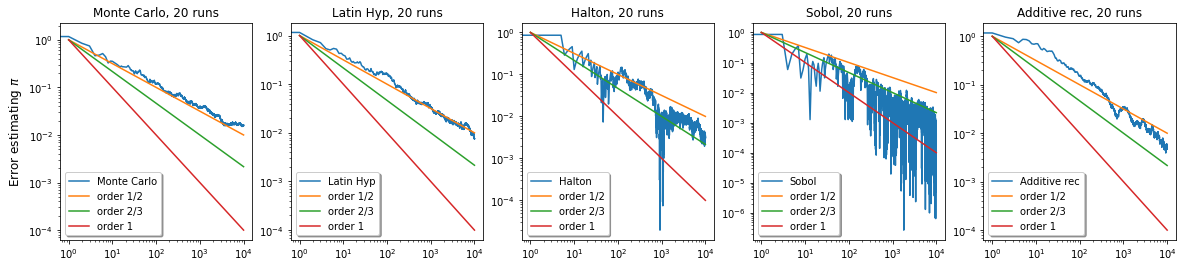

In [80]:
#Number of samples per batch
nSamples=10000

#Number of batches
nBatches=20

for i in range(nBatches):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  if i==0:
    [err , labels] = giveError(nSamples)
  else:
    err=err + giveError(nSamples)[0]

err = np.divide(err, nBatches)

#Plot results
fig, ax = plt.subplots(1,K,figsize=(4*K, 4))
for k in range(K):

  #label axes 
  ax[k].set_title("{0}, {1} runs".format(labels[k], nBatches))

  if k==0:
    ax[k].set_ylabel('Error estimating $\pi$', rotation=90, size='large')

  ax[k].loglog(err[:,k],label=labels[k])
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.sqrt(range(1,nSamples+1))),label='order 1/2')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,np.arange(1,nSamples+1)**(2/3)),label='order 2/3')
  ax[k].loglog(range(1,nSamples+1),np.divide(1,range(1,nSamples+1)),label='order 1')

  #label curves
  ax[k].legend(shadow=True, fancybox=True)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   c) Interpret the graph created by c) and comment on random numbers vs. quasi random numbers (or Monte-Carlo vs. Quasi-Monte-Carlo).

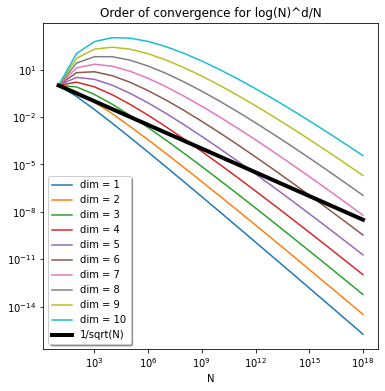

In [8]:
#Compute and plot log(N)^d/N for different values of N and d
toNormalize=True

N=10**np.arange(1,19)

plt.figure(figsize=(6,6))
for d in range(1,11):
  err=np.divide(np.log(N)**d,N)
  if toNormalize:
    err = np.divide(err,err[0])
  plt.loglog(N, err,label="dim = {0}".format(d))

err = np.divide(1,np.sqrt(N))

if toNormalize:
  err = np.divide(err, err[0])

plt.loglog(N,err,label="1/sqrt(N)", c="black",linewidth=4)
plt.title("Order of convergence for log(N)^d/N")
plt.xlabel("N")
_ = plt.legend(shadow=True, fancybox=True,loc='lower left')

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   d) It is often said, that Monte-Carlo does not suffer from the Curse of dimensionality.          
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   How does this statement and the observations from d) fit together?

&nbsp; 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   *Note: Don't worry if the graph doesn't appear immediately, computation can take a minute*

In [ ]:
def volb1(dim):
  return math.pi**(dim/2)/math.gamma(dim/2 + 1)

volb= np.vectorize(volb1)

def volc(dim):
  return 2**dim
  
#Halton set
dim = 10
nSamples = 10**np.arange(1,7)
nBatches = 20
error = np.empty((np.size(nSamples),dim))

sequencer=ghalton.Halton(dim)

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))

  for i in range(np.size(nSamples)):
    n=nSamples[i]
    inside = np.empty((n,dim),dtype=bool)
    #r=np.random.randint(0,nSamples[np.size(nSamples)-1]-n+1)
    #p=sample[r:r+n-1,:]
    p= sequencer.get(int(n))
    #p=np.random.shuffle(p)
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)


plt.figure(figsize=(10,8))
colormap = plt.cm.hsv
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.hsv(np.linspace(0, 1, dim))))
for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="Halton {0}".format(d+1),linestyle='dashed')


 #Uniform random numbers

for batch in range(1,nBatches+1):
  #print("Batch {0} of {1}".format(i+1,nBatches))
  i=0
  for n in nSamples:
    inside = np.empty((n,dim),dtype=bool)
    p=np.random.uniform(0,1,(int(n),dim))
    s= 2*np.subtract(p,0.5)
    s=np.cumsum(s**2,1)
    inside = sum(s <= 1)
    volbmc = np.multiply(np.divide(inside,n),volc(np.arange(1,dim+1)))
    error [i,:]= np.divide(np.absolute(volbmc - volb(np.arange(1,dim+1))),volb(np.arange(1,dim+1)))
    i = i+1

  if batch==1:
    Error=error
  else:
    Error= Error + error

Error = np.divide(Error,nBatches)

colormap = plt.cm.hsv
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.hsv(np.linspace(0, 1, dim))))
for d in range(1,dim):
  plt.loglog(nSamples, Error[:,d], label="MC {0}".format(d+1))

_ = plt.legend(shadow=True, fancybox=True,loc='upper right')

**EXERCISE 2)**

Verify some details used in the sparse grid error estimates:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (a) Show that the number of nodes $n$ of stage $l$ in the dimension $d$ used in a sparse grid satisfies 

$$n(d,l) \leq 2^l {l+d-2 \choose d-1}$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     if $R_l \leq 2^{l-1}$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    *Hint:* 
$$n(d,l) \leq \sum_{|l'|\leq l+d-1} 2^{|l'-1|}.$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (b) Let 
$$ \|f\|_{H^1} = f(0) + \|f'\|_{L^2} $$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    Show that if in 1D                                                                                             $$|\Delta_l^{(1)}f| \leq 2^{-l+1} \|f\|_{H^1} \;\;,$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    then 
$$|\Delta_{l_1}^{(1)} \otimes \cdot \cdot \cdot \otimes \Delta_{l_p}^{(1)}f| \leq b_l \|f\|_{H^1} \;\;,$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    where $b_l = 2^{-|l-1|}$, and $l$ is a multi-index $l=(l_1,...,l_d).$

&nbsp;

**EXERCISE 3)**

In this exercise, we prove the properties of Legendre polynomials that were used in the lecture. 
 
 We define the Legendre polynomial of degree $n$ by 
 $$ P_n(x) = \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2 -1)^n \;.$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (a) Show that $P_n$ is indeed a polynomial of degree $n$.
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (b) Show that the leading coefficient (i.e. the coefficient in front of $x^n$) is 
 $$\frac{(2n)!}{2^n (n!)^2} \;.$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (c) Show that the Legendre polynomials are orthogonal with respect to the standard inner product
 $$(f,g) = \int_{-1}^1 f(x)g(x) dx \;,$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     more specifically that
 $$(P_l,P_m) = \frac{2}{2l+1} \delta_{lm} \;.$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     *Hint:* Show that for any sufficiently smooth function 
 $$2^n n! (f,P_n) = (-1)^n \int_{-1}^{1} f^{(n)}(x)(x^2-1)^n dx $$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     and use 
 $$ \int_0^1 (1-y)^n y^{-1/2} dy = \frac{2^{n+1}n!}{1 \cdot 3 \cdot \cdot \cdot (2n+1)} \;.$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (d) Show that the $P_n$ are eigenfunctions of a different operator in the following sense
 $$\frac{d}{dx} \left((1-x^2)\frac{d}{dx}P_n(x)\right) = -n (n+1) P_n(x) \;.$$
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     *Hint:* Denote the left hand side by $g$. Show that $g+n(n+1)P_n$ is a polynomial of degree $n-1$, express it as a linear combination of $P_0,...,P_{n-1}$ and use orthogonality. 
